# Expected Goals Model

Load in pickled preprocessed data, separate into train and test split and train Logistic Regression

In [2]:
import sys
import os

import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import FCPython

import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

import Metrica_Functions_TLMAnalytics as mfun

## Preprocess StatsBomb Event Data

### Load Events

In [3]:
# Get competition ids for relevant competitions
comps = pd.read_json('open-data-master/data/competitions.json')
male_comps = comps[comps['competition_gender'] == 'male']
male_comps_id = list(male_comps['competition_id'].unique())
male_comps_id

[16, 43, 11, 2]

In [4]:
# For those competitions, identify the match ids
male_df_list = []
for comp in male_comps_id:
    json_files = [x for x in os.listdir('open-data-master/data/matches/' + str(comp)) if 'json' in x]
    for event_json in json_files:
        male_df = pd.read_json('open-data-master/data/matches/' + str(comp) + '/' + event_json)
        male_df_list.append(male_df)

male_df = pd.concat(male_df_list)
male_matches = list(male_df['match_id'].unique())

In [5]:
# For those matches, load the events and append to single dataframe
json_files = [int(x.split('.')[0]) for x in os.listdir('open-data-master/data/events') if 'json' in x]
male_matches = [x for x in json_files if x  in male_matches]
df_list = []
count = 1
for event_json in male_matches:
    print('Loading: {}. {} / {}'.format(event_json, count, len(male_matches)))
    df = pd.read_json('open-data-master/data/events/' + str(event_json) + '.json')
    df['match_id'] = event_json
    df_list.append(df)
    count +=1
    
df = pd.concat(df_list)

Loading: 15946. 1 / 596
Loading: 15956. 2 / 596
Loading: 15973. 3 / 596
Loading: 15978. 4 / 596
Loading: 15986. 5 / 596
Loading: 15998. 6 / 596
Loading: 16010. 7 / 596
Loading: 16023. 8 / 596
Loading: 16029. 9 / 596
Loading: 16056. 10 / 596
Loading: 16073. 11 / 596
Loading: 16079. 12 / 596
Loading: 16086. 13 / 596
Loading: 16095. 14 / 596
Loading: 16109. 15 / 596
Loading: 16120. 16 / 596
Loading: 16131. 17 / 596
Loading: 16136. 18 / 596
Loading: 16149. 19 / 596
Loading: 16157. 20 / 596
Loading: 16173. 21 / 596
Loading: 16182. 22 / 596
Loading: 16190. 23 / 596
Loading: 16196. 24 / 596
Loading: 16205. 25 / 596
Loading: 16215. 26 / 596
Loading: 16231. 27 / 596
Loading: 16240. 28 / 596
Loading: 16248. 29 / 596
Loading: 16265. 30 / 596
Loading: 16275. 31 / 596
Loading: 16289. 32 / 596
Loading: 16306. 33 / 596
Loading: 16317. 34 / 596
Loading: 18235. 35 / 596
Loading: 18236. 36 / 596
Loading: 18237. 37 / 596
Loading: 18240. 38 / 596
Loading: 18241. 39 / 596
Loading: 18242. 40 / 596
Loading: 

Loading: 69170. 312 / 596
Loading: 69171. 313 / 596
Loading: 69172. 314 / 596
Loading: 69173. 315 / 596
Loading: 69174. 316 / 596
Loading: 69175. 317 / 596
Loading: 69176. 318 / 596
Loading: 69177. 319 / 596
Loading: 69178. 320 / 596
Loading: 69179. 321 / 596
Loading: 69180. 322 / 596
Loading: 69181. 323 / 596
Loading: 69182. 324 / 596
Loading: 69183. 325 / 596
Loading: 69184. 326 / 596
Loading: 69185. 327 / 596
Loading: 69186. 328 / 596
Loading: 69187. 329 / 596
Loading: 69189. 330 / 596
Loading: 69195. 331 / 596
Loading: 69207. 332 / 596
Loading: 69209. 333 / 596
Loading: 69210. 334 / 596
Loading: 69211. 335 / 596
Loading: 69212. 336 / 596
Loading: 69213. 337 / 596
Loading: 69214. 338 / 596
Loading: 69215. 339 / 596
Loading: 69216. 340 / 596
Loading: 69217. 341 / 596
Loading: 69218. 342 / 596
Loading: 69219. 343 / 596
Loading: 69220. 344 / 596
Loading: 69221. 345 / 596
Loading: 69222. 346 / 596
Loading: 69223. 347 / 596
Loading: 69224. 348 / 596
Loading: 69225. 349 / 596
Loading: 692

### Filter Shot Events

In [6]:
shots = df[~df['shot'].isnull()]
shots.reset_index(drop = True, inplace = True)
shots.head(3)

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,match_id,clearance,off_camera,miscontrol,50_50,out,injury_stoppage,half_start,player_off,half_end
0,65f16e50-7c5d-4293-b2fc-d20887a772f9,148,1,2021-01-03 00:02:29.094,2,29,"{'id': 16, 'name': 'Shot'}",6,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}",...,15946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,b0f73423-3990-45ae-9dda-3512c2d1aff3,283,1,2021-01-03 00:05:39.239,5,39,"{'id': 16, 'name': 'Shot'}",11,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}",...,15946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13b1ddab-d22e-43d9-bfe4-12632fea1a27,755,1,2021-01-03 00:15:28.625,15,28,"{'id': 16, 'name': 'Shot'}",26,"{'id': 217, 'name': 'Barcelona'}","{'id': 8, 'name': 'From Keeper'}",...,15946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Create Expected Goal Features

In [18]:
left_post_x, left_post_y = (120, 36)
right_post_x, right_post_y = (120, 44)

shots_model=pd.DataFrame(columns=['goal','x','y'])
for index, shot in shots.iterrows():
    
    # Keep only open play
    open_play = 0
    if shot['shot']['type']['name'] == 'Open Play':
        open_play = 1

    # Keep non-headed shots
    header = 0
    if shot['shot']['body_part']['name'] == 'Head':
        header = 1
    if (open_play == 1) & (header == 0):
        # Goal
        if shot['shot']['outcome']['name'] == 'Goal':
            shots_model.loc[index, 'goal'] = 1
        else:
            shots_model.loc[index, 'goal'] = 0

        # X, Y locations
        shot_location_x, shot_location_y = shot['location']
        shots_model.loc[index, 'x'] = shot_location_x
        shots_model.loc[index, 'y'] = shot_location_y
        shots_model.loc[index,'c']=abs(shot_location_y-40)

        # Distance to centre of goal and angle
        shots_model.loc[index,'distance']=np.sqrt((120-shot_location_x)**2 + (40-shot_location_y)**2)
        
        # Angle to goal (radians)
        a = np.sqrt((shot_location_x - right_post_x)**2 + (shot_location_y - right_post_y)**2)
        b = np.sqrt((left_post_x - right_post_x)**2 + (left_post_y - right_post_y)**2)
        c = np.sqrt((left_post_x - shot_location_x)**2 + (left_post_y - shot_location_y)**2)
        angle_ac = np.arccos((a**2 + c**2 - b**2)/(2*a*c))
        if angle_ac<0:
            angle_ac=np.pi+angle_ac
        shots_model.loc[index,'angle'] =angle_ac

        # Play pattern
        shots_model.loc[index, 'play_pattern'] = shot['play_pattern']['name']

        # Body part
        shots_model.loc[index, 'body_part'] = shot['shot']['body_part']['name']

        # First time
        shots_model.loc[index, 'first_time'] = 0
        if 'first_time' in shot['shot'].keys():
            shots_model.loc[index, 'first_time'] = 1

        # Technique
        shots_model.loc[index, 'technique'] = shot['shot']['technique']['name']

        # Pressure
        shots_model.loc[index, 'under_pressure'] = 0
        if shot['under_pressure'] == True:
            shots_model.loc[index, 'under_pressure'] = 1

        # Freeze Frame - defender location
        # Number of defenders between shot location and goal
        # Distance to nearest defender between shot location and goal
        # Distance to nearest defender
        # TBD: position of nearest defender
        # TBD: angle of goal left after removing blocked defenders (assume ~1m width)
        
        freeze_frame_def = []
        for player in shot['shot']['freeze_frame']:
            if player['teammate'] == False:
                freeze_frame_def.append(player)
        
        distance_nearest_defender = None
        distance_nearest_blocking_defender = None
        blocking_defender = []
        for defender in freeze_frame_def:
            # defender specific
            defender_x, defender_y = defender['location']
            distance_defender = np.sqrt((shot_location_x - defender_x)**2 + (shot_location_y - defender_y)**2)
            if distance_nearest_defender == None:
                distance_nearest_defender = distance_defender
            elif distance_defender < distance_nearest_defender:
                distance_nearest_defender = distance_defender
            distance_defender = None

            blocking = mfun.is_inside(shot_location_x, shot_location_y
                                , left_post_x, left_post_y
                                , right_post_x, right_post_y
                                , defender_x, defender_y)
            if blocking == True:
                # If defender is blocking part of the goal..
                blocking_defender.append(defender)

                # Measure distance of blocking defender
                distance_blocking_defender = np.sqrt((shot_location_x - defender_x)**2 + (shot_location_y - defender_y)**2)
                
                if distance_nearest_blocking_defender == None:
                    distance_nearest_blocking_defender = distance_blocking_defender
                elif distance_blocking_defender < distance_nearest_blocking_defender:
                    distance_nearest_blocking_defender = distance_blocking_defender
                distance_blocking_defender = None
        
        shots_model.loc[index, 'distance_nearest_defender'] = distance_nearest_defender
        shots_model.loc[index, 'distance_nearest_blocking_defender'] = distance_nearest_blocking_defender
        shots_model.loc[index, 'number_blocking_defenders'] = len(blocking_defender)

        
        # Key Pass info
        # TBD - get info from previous pass
        # Eg. cross / through ball / where it was etc
        
        # StatsBomb xG
        shots_model.loc[index, 'statsbomb_xg'] = shot['shot']['statsbomb_xg']

# # Make locations numeric
# shots_model['x'] = pd.to_numeric(shots_model['x'])
# shots_model['y'] = pd.to_numeric(shots_model['y'])

# # Try squared distances
# shots_model['d2'] = shots_model['distance']**2
# shots_model['x2'] = shots_model['x']**2
# shots_model['c2'] = shots_model['c']**2
# # Try angle * x location
# shots_model['ax'] = shots_model['angle']*shots_model['x']

C:\Users\Ciaran\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in arccos


### Save Preprocessed Data

In [19]:
shots_model.to_pickle("./shots_model.pkl")

## Expected Goals Model

### Load Shot Data

In [20]:
# Load shot model
shots_model = pd.read_pickle("./shots_model.pkl")
shots_model.head()

,goal,x,y,c,distance,angle,play_pattern,body_part,first_time,technique,under_pressure,distance_nearest_defender,distance_nearest_blocking_defender,number_blocking_defenders,statsbomb_xg
0,0,111.7,51.7,11.7,14.345034,0.336567,Regular Play,Right Foot,1.0,Half Volley,0.0,1.303840,NaN,0.0,0.075164
1,0,114,27,13.0,14.317821,0.248710,Regular Play,Left Foot,1.0,Volley,0.0,3.700000,NaN,0.0,0.062892
2,0,92,34.5,5.5,28.535066,0.273578,From Keeper,Left Foot,0.0,Normal,0.0,2.884441,5.124451,1.0,0.020535
4,0,107,25,15.0,19.849433,0.268489,From Corner,Right Foot,0.0,Normal,0.0,3.244996,NaN,0.0,0.035420
5,0,108.1,27.4,12.6,17.331186,0.323048,Regular Play,Left Foot,1.0,Half Volley,1.0,2.039608,NaN,0.0,0.089920


### Separate into Train/Test Data

In [21]:
# Separate into train, test data for modelling
X_train, X_test, y_train, y_test = train_test_split(shots_model.loc[:, shots_model.columns != 'goal']
                                                    , shots_model.loc[:, shots_model.columns == 'goal']
                                                    , test_size=0.2, random_state=42)
train = pd.concat([y_train, X_train], axis=1)
test = pd.concat([y_test, X_test], axis=1)

### Logistic Regression

In [22]:
# A GLM for fitting goal probability
model_variables = ['distance'
                   , 'angle'
                   , 'distance_nearest_defender'
                   , 'number_blocking_defenders'
                   ]

model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

#Fit the model
xG_model = smf.glm(formula="goal ~ " + model, data=train, 
                           family=sm.families.Binomial()).fit()
print(xG_model.summary())        
xG_model_params=xG_model.params

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['goal[0]', 'goal[1]']   No. Observations:                 9295
Model:                                GLM   Df Residuals:                     9290
Model Family:                    Binomial   Df Model:                            4
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2901.7
Date:                    Sun, 03 Jan 2021   Deviance:                       5803.5
Time:                            11:31:04   Pearson chi2:                 9.45e+03
No. Iterations:                         6                                         
Covariance Type:                nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

### Calculate xG on Test data

In [23]:
# Calculate xG for GLM using each shot as input (row of shots_model)
def calculate_xG(sh):
    # For the model 'b', get the intercept
    bsum=xG_model_params[0]
    # For as many variables as put in the model, 
    # multiply the coefficient by the value of that shot.
    for i,v in enumerate(model_variables):
        # bsum = intercept + (coefficient * variable value)
        bsum=bsum+xG_model_params[i+1]*sh[v]
    # Calculate probability of goal as 1 / 1 + exp(model output)
    xG = 1/(1+np.exp(bsum)) 
    return xG   

In [24]:
#Add an xG to my dataframe
train_xG=train.apply(calculate_xG, axis=1)
train['xG'] = train_xG

test_xG=test.apply(calculate_xG, axis=1)
test['xG'] = test_xG
test.tail()

,goal,x,y,c,distance,angle,play_pattern,body_part,first_time,technique,under_pressure,distance_nearest_defender,distance_nearest_blocking_defender,number_blocking_defenders,statsbomb_xg,xG
3580,0,102.5,23.8,16.2,23.847222,0.248088,From Corner,Right Foot,0.0,Normal,0.0,3.894868,NaN,0.0,0.025732,0.060465
13598,0,115,26,14.0,14.866069,0.192701,Regular Play,Left Foot,1.0,Normal,0.0,5.000000,10.440307,1.0,0.052736,0.113889
4691,0,102.1,36.3,3.7,18.278403,0.422998,Regular Play,Left Foot,0.0,Half Volley,0.0,1.664332,NaN,0.0,0.047882,0.105522
8187,1,112.5,38.1,1.9,7.736924,0.939567,From Goal Kick,Right Foot,0.0,Normal,0.0,1.204159,NaN,0.0,0.354846,0.444201
675,0,117.4,30.7,9.3,9.656604,0.263018,Regular Play,Left Foot,0.0,Normal,0.0,3.605551,NaN,0.0,0.520617,0.227407


### Model Evaluation

#### Check (x, y) Probabilities by # Defenders and Distance to Nearest Defenders

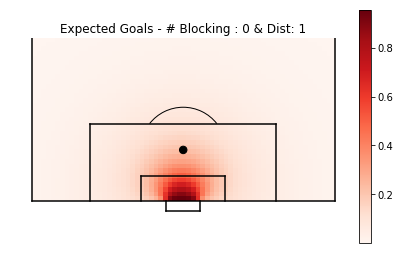

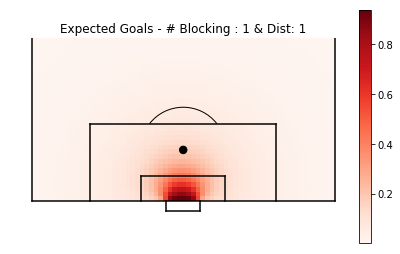

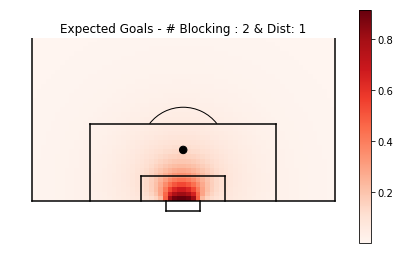

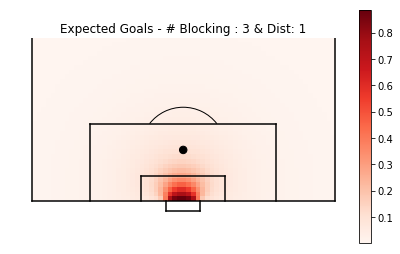

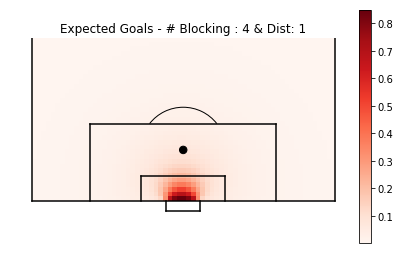

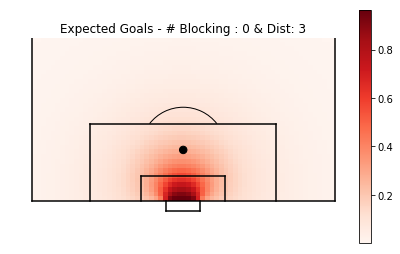

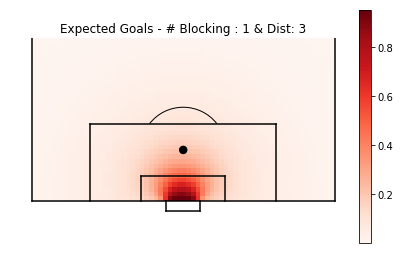

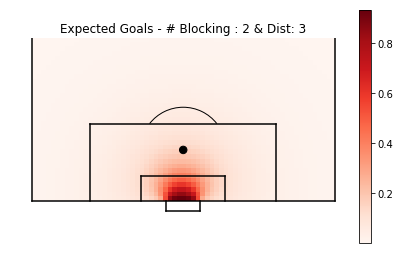

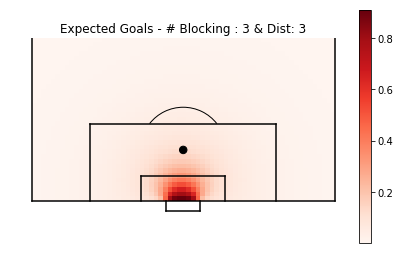

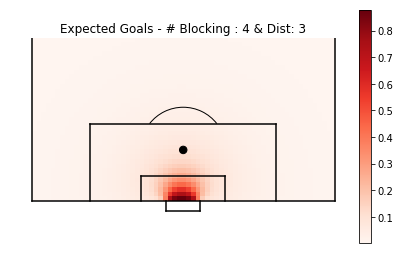

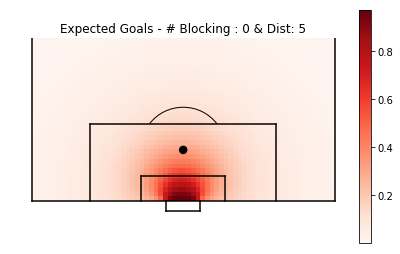

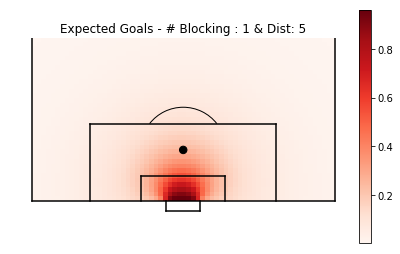

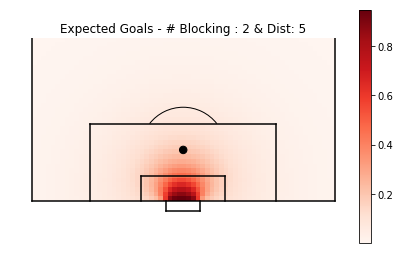

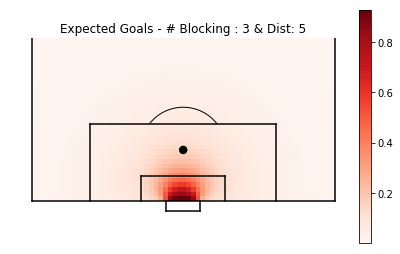

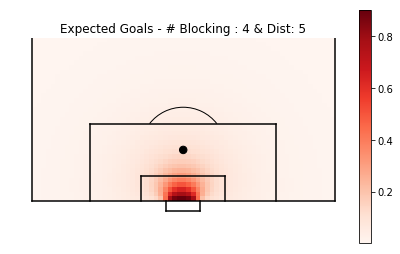

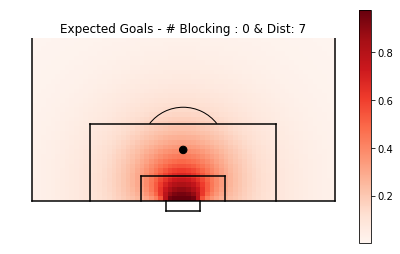

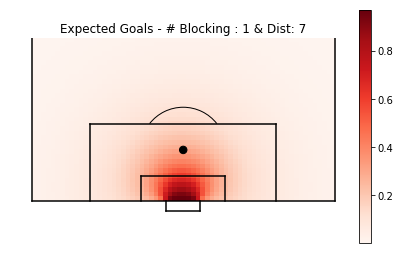

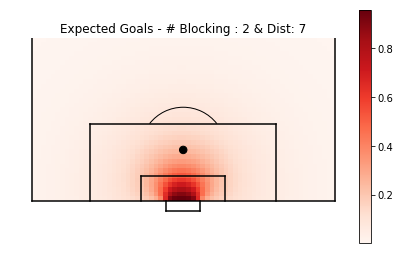

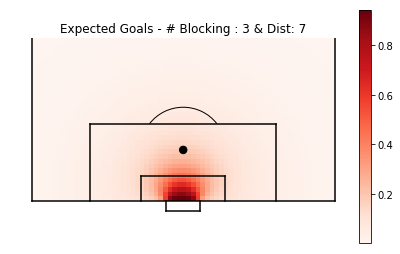

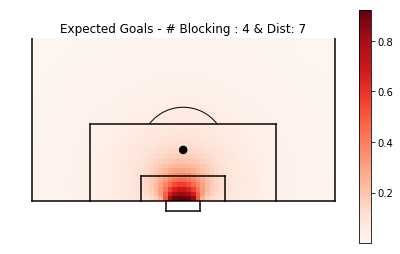

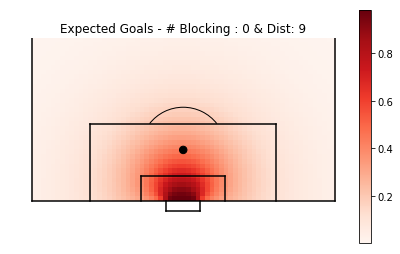

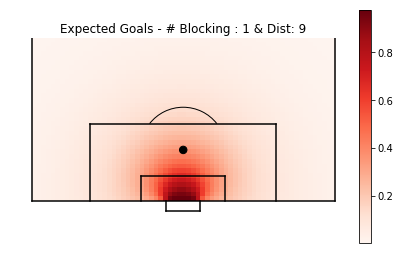

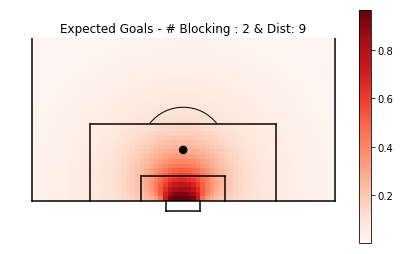

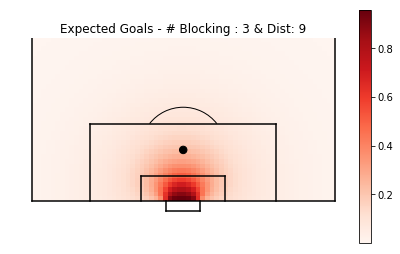

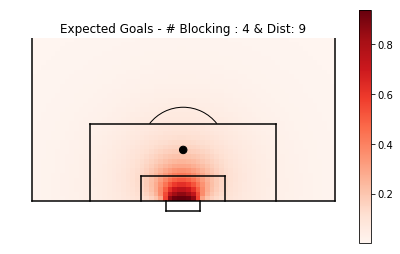

In [25]:
left_post_x, left_post_y = (65, (36/80)*65)
right_post_x, right_post_y = (65, (44/80)*65)

for dist_defender in range(1, 10, 2):
    for num_blocking_defenders in range(5):
        xG_2d = np.zeros((65,65))
        # For each x, y grid calculate xG
        for x in range(65):
            for y in range(65):
                shot={}

                # Distance to centre of goal and angle
                shot['distance']=np.sqrt((65-x)**2 + (65/2-y)**2)

                # Angle to goal (radians)
                a = np.sqrt((x - right_post_x)**2 + (y - right_post_y)**2)
                b = np.sqrt((left_post_x - right_post_x)**2 + (left_post_y - right_post_y)**2)
                c = np.sqrt((left_post_x - x)**2 + (left_post_y - y)**2)
                angle_ac = np.arccos((a**2 + c**2 - b**2)/(2*a*c))
                if angle_ac<0:
                    angle_ac=np.pi+angle_ac
                shot['angle'] =angle_ac

                shot['distance_nearest_defender'] = dist_defender
                shot['number_blocking_defenders'] = num_blocking_defenders

                xG_2d[64-x,64-y] =  calculate_xG(shot)

        (fig,ax) = FCPython.createGoalMouth()
        pos=ax.imshow(xG_2d, aspect = 'auto', origin="lower", extent=(0, 65, 0, 65), cmap=plt.cm.Reds)
        fig.colorbar(pos, ax=ax)
        ax.set_title('Expected Goals - # Blocking : '+str(num_blocking_defenders) + ' & Dist: ' + str(dist_defender))
        plt.xlim((-1,66))
        plt.ylim((-3,35))
        plt.tight_layout()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

#### StatsBomb Comparison

There is a positive correlation between the logistic regression model and StatsBomb's own model, which is reassuring. It's not nearly as sophisticated, but seems to generally work as intended after looking at the previous shot location probabilities depending on number of blocking defenders and distance to nearest defenders.

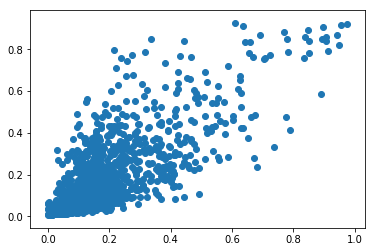

In [26]:
plt.scatter(test['xG'], test['statsbomb_xg'])
plt.show()